# Load Modules

In [291]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
from imblearn.over_sampling import SMOTE

# Load Data

In [29]:
# Features to be used
phot_flux = [
    "photflux_aper_s",
    "photflux_aper_b",
    "photflux_aper_u",
    "photflux_aper_h",
    "photflux_aper_m",
]
en_flux = [
    "flux_aper_s",
    "flux_aper_h",
    "flux_aper_b",
    "flux_aper_u",
    "flux_aper_m",
]
hard = [
    "hard_hm",
    "hard_hs",
    "hard_ms",
]
powlaw_fit = [
    "flux_powlaw",
    "powlaw_gamma",
    "powlaw_nh",
    "powlaw_ampl",
    "powlaw_stat",
]

bb_fit = [
    "flux_bb",
    "bb_kt",
    "bb_nh",
    "bb_ampl",
    "bb_stat",
]
brems_fit = [
    "flux_brems",
    "brems_kt",
    "brems_nh",
    "brems_norm",
    "brems_stat",
]

intra_obs_var = [
    "var_prob_b",
    "ks_prob_b",
    "kp_prob_b",
    "var_sigma_b",
    "var_mean_b",
    "var_min_b",
    "var_max_b",
    "var_index_h",
    "var_prob_h",
    "ks_prob_h",
    "kp_prob_h",
    "var_sigma_h",
    "var_mean_h",
    "var_min_h",
    "var_max_h",
    "var_index_m",
    "var_prob_m",
    "ks_prob_m",
    "kp_prob_m",
    "var_sigma_m",
    "var_mean_m",
    "var_min_m",
    "var_max_m",
    "var_index_s",
    "var_prob_s",
    "ks_prob_s",
    "kp_prob_s",
    "var_sigma_s",
    "var_mean_s",
    "var_min_s",
    "var_max_s",
    "var_index_u",
    "var_prob_u",
    "ks_prob_u",
    "kp_prob_u",
    "var_sigma_u",
    "var_mean_u",
    "var_min_u",
    "var_max_u",
]

inter_ob_var = [
    "var_inter_index_b",
    "var_inter_prob_b",
    "var_inter_sigma_b",
    "var_inter_index_h",
    "var_inter_prob_h",
    "var_inter_sigma_h",
    "var_inter_index_m",
    "var_inter_prob_m",
    "var_inter_sigma_m",
    "var_inter_index_s",
    "var_inter_prob_s",
    "var_inter_sigma_s",
    "var_inter_index_u",
    "var_inter_prob_u",
    "var_inter_sigma_u",
]

info_col = [
'src_id',
 'num_obs',
 'sepn',
 'name',
 'ra',
 'dec',
 'livetime',
 'significance',
 'likelihood',
]


In [30]:
feat_to_use = info_col + phot_flux + en_flux + powlaw_fit +bb_fit +hard+ intra_obs_var +inter_ob_var 
data_cv = pd.read_csv('cv_data.csv' , index_col='obs_id')[feat_to_use]
data_cv.insert(0 , 'class' , ['CV']*len(data_cv))
data_pl  =  pd.read_csv('pulsar_data.csv' , index_col = 'obs_id')[feat_to_use]
data_pl.insert(0 , 'class' , ['PL']*len(data_pl))

data_lx  =  pd.read_csv('lmxb_data.csv' , index_col = 'obs_id')[feat_to_use]
data_lx.insert(0 , 'class' , ['LX']*len(data_lx))

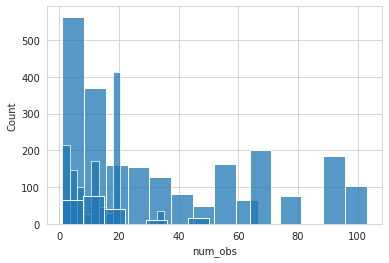

In [31]:
sns.histplot(data_cv['num_obs'])
sns.histplot(data_pl['num_obs'])
sns.histplot(data_lx['num_obs'])
plt.show()

In [32]:
data_cv

,class,src_id,num_obs,sepn,name,ra,dec,livetime,significance,likelihood,...,var_inter_sigma_h,var_inter_index_m,var_inter_prob_m,var_inter_sigma_m,var_inter_index_s,var_inter_prob_s,var_inter_sigma_s,var_inter_index_u,var_inter_prob_u,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,4103.7,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_1,CV,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_2,CV,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_3,CV,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3904.6,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_4,CV,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CV_309_obs_0,CV,CV_309,1,0.877141,2CXO J174311.1-271622,265.79630,-27.27295,2156.9,2.53,20.88602,...,0.000004,5.0,0.802,1.246000e-06,NaN,NaN,NaN,NaN,NaN,NaN
CV_310_obs_0,CV,CV_310,1,3.687046,2CXO J040556.8+714816,61.48706,71.80466,28678.8,4.86,53.30116,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_311_obs_0,CV,CV_311,1,0.073509,2CXO J191051.9-595840,287.71650,-59.97791,37966.9,2.61,27.11662,...,NaN,6.0,0.983,1.822000e-07,5.0,0.774,1.036000e-07,NaN,NaN,NaN


In [33]:
data = pd.concat([data_cv , data_pl , data_lx] , axis=0)
data

,class,src_id,num_obs,sepn,name,ra,dec,livetime,significance,likelihood,...,var_inter_sigma_h,var_inter_index_m,var_inter_prob_m,var_inter_sigma_m,var_inter_index_s,var_inter_prob_s,var_inter_sigma_s,var_inter_index_u,var_inter_prob_u,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.272150,4103.7,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_1,CV,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_2,CV,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_3,CV,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.272150,3904.6,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_4,CV,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_90_obs_0,LX,LMXB_90,1,0.000000,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMXB_91_obs_0,LX,LMXB_91,1,0.000000,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,...,8.934000e-09,5.0,0.800,1.257000e-07,0.0,0.247,5.992000e-09,NaN,NaN,NaN
LMXB_92_obs_0,LX,LMXB_92,1,0.000000,2CXO J092920.1-312303,142.33410,-31.384270,24445.9,3.70,75.53454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Remove sparse columns

In [34]:
sp = [] 
for f in feat_to_use:
    #print(f)
    na = data[feat_to_use][f].isna().value_counts()
    try:
        sp.append( float(1-na[0]/(na[0]+na[1])))
    except:
        sp.append(0)
sp =  np.asarray(sp)
sparsity = pd.DataFrame(
    {
        "feat" : feat_to_use ,
        "sp_val" :sp
    }
).sort_values(by='sp_val' , ascending=False).reset_index(drop=True)
sparsity

,feat,sp_val
0,var_index_u,0.88916
1,var_max_u,0.88916
2,var_min_u,0.88916
3,var_mean_u,0.88916
4,var_sigma_u,0.88916
...,...,...
81,ra,0.00000
82,dec,0.00000
83,livetime,0.00000
84,significance,0.00000


In [35]:
feat_low_sparse = sparsity[sparsity['sp_val']<0.5].sort_values(by='sp_val').reset_index(drop=True)
feat_low_sparse = feat_low_sparse['feat'].to_list()

In [36]:
data_use = data[['class']+feat_low_sparse]
data_use

,class,src_id,num_obs,likelihood,sepn,significance,ra,dec,livetime,name,...,var_inter_prob_h,var_inter_sigma_h,flux_aper_u,var_max_b,var_prob_b,ks_prob_b,kp_prob_b,var_sigma_b,var_mean_b,var_min_b
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV,CV_0,25,16618.73000,0.157954,52.93,10.69654,41.272150,4103.7,2CXO J004247.1+411619,...,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_1,CV,CV_0,25,16618.73000,0.157954,52.93,10.69654,41.272150,3907.5,2CXO J004247.1+411619,...,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_2,CV,CV_0,25,16618.73000,0.157954,52.93,10.69654,41.272150,3907.5,2CXO J004247.1+411619,...,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_3,CV,CV_0,25,16618.73000,0.157954,52.93,10.69654,41.272150,3904.6,2CXO J004247.1+411619,...,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_4,CV,CV_0,25,16618.73000,0.157954,52.93,10.69654,41.272150,3907.5,2CXO J004247.1+411619,...,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_90_obs_0,LX,LMXB_90,1,132.76700,0.000000,4.06,320.81060,-5.798128,17705.1,2CXO J212314.5-054753,...,NaN,NaN,1.538000e-15,0.003517,0.807,0.265,0.211,0.000255,0.001171,0.001060
LMXB_91_obs_0,LX,LMXB_91,1,114.24570,0.000000,4.89,263.94590,-30.482820,18855.8,2CXO J173547.0-302858,...,0.234,8.934000e-09,0.000000e+00,0.002756,0.451,0.735,0.547,0.000211,0.001623,0.001488
LMXB_92_obs_0,LX,LMXB_92,1,75.53454,0.000000,3.70,142.33410,-31.384270,24445.9,2CXO J092920.1-312303,...,NaN,NaN,2.836000e-15,0.001005,0.607,0.940,0.789,0.000201,0.000740,0.000511


In [37]:
cva = data_use.query('src_id=="CV_0"')

## Take log

In [39]:
flux_feat = [
    'photflux_aper_m' , 
    'flux_aper_h' , 
    'flux_aper_u',
    'photflux_aper_b' , 
    'flux_aper_m',
    'flux_aper_s',
    'photflux_aper_h' , 
    'photflux_aper_s', 
    'photflux_aper_u' , 
    'flux_aper_b' , 
]
def take_log(data_sent):
    x_train_log = data_sent.copy()
    for f in flux_feat[:]:
        x_train_log.loc[:,f] = -(np.log10(x_train_log.loc[:,f]))
    x_train_log = x_train_log.replace(-np.inf , np.nan)
    x_train_log = x_train_log.replace(np.inf , np.nan)
    return x_train_log

## Imputation

In [40]:
df_log = take_log(data_use)
info_col_cl = info_col+['class']
src_list = np.unique(df_log['src_id'])
df_all_imp = pd.DataFrame()
for s in tqdm(src_list[:]):
    print('----------------------------------')
    print(s)
    temp = df_log[df_log['src_id']==s]
    temp_val = temp.drop(columns=info_col_cl)
    temp_id = temp[info_col_cl]
    rf_imputer = MissForest(verbose=0 , decreasing=True)
    #new_data = d.drop(columns= ['class'])
    try:
        new_data = rf_imputer.fit_transform(temp_val)
        imp_data =  pd.DataFrame(new_data , columns = temp_val.columns.to_list()  , index=temp_val.index.to_list())
        imp_data.index.name = 'obs_id'
    except:
        print('all col missing')
        imp_data = temp_val
    temp_imp = pd.concat([temp_id , imp_data] , axis = 1)
    df_all_imp = df_all_imp.append(temp_imp)
    #display(temp)
    #display(temp_val)
display(df_all_imp)

/home/kumaran/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 0/605 [00:00<?, ?it/s]

----------------------------------
CV_0
all col missing
----------------------------------
CV_1
Iteration: 0
Iteration: 1


  0%|          | 2/605 [00:15<1:19:28,  7.91s/it]

Iteration: 2
----------------------------------
CV_10
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


  0%|          | 3/605 [00:48<3:01:21, 18.08s/it]

Iteration: 5
----------------------------------
CV_100
all col missing
----------------------------------
CV_101
Iteration: 0
Iteration: 1
Iteration: 2


  1%|          | 5/605 [01:10<2:23:28, 14.35s/it]

Iteration: 3
----------------------------------
CV_102
all col missing
----------------------------------
CV_103
all col missing
----------------------------------
CV_104
all col missing
----------------------------------
CV_105
----------------------------------
CV_106


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


  2%|▏         | 10/605 [01:12<50:35,  5.10s/it] 

Iteration: 2
----------------------------------
CV_107
all col missing
----------------------------------
CV_108
----------------------------------
CV_109
----------------------------------
CV_11
all col missing
----------------------------------
CV_110


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


  2%|▏         | 15/605 [01:23<36:16,  3.69s/it]

Iteration: 2
----------------------------------
CV_111
all col missing
----------------------------------
CV_112
----------------------------------
CV_113


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2


  3%|▎         | 18/605 [01:30<32:42,  3.34s/it]

Iteration: 3
----------------------------------
CV_114
Iteration: 0
Iteration: 1


  3%|▎         | 19/605 [01:32<30:38,  3.14s/it]

Iteration: 2
----------------------------------
CV_115
Iteration: 0
Iteration: 1
Iteration: 2


  3%|▎         | 20/605 [01:52<54:52,  5.63s/it]

Iteration: 3
----------------------------------
CV_116
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


  3%|▎         | 21/605 [02:17<1:28:44,  9.12s/it]

Iteration: 4
----------------------------------
CV_117
all col missing
----------------------------------
CV_118
Iteration: 0
Iteration: 1


  4%|▍         | 23/605 [02:19<1:01:38,  6.35s/it]

Iteration: 2
----------------------------------
CV_119
all col missing
----------------------------------
CV_12
all col missing
----------------------------------
CV_120
Iteration: 0


  4%|▍         | 26/605 [02:21<38:37,  4.00s/it]  

Iteration: 1
----------------------------------
CV_122
all col missing
----------------------------------
CV_123
all col missing
----------------------------------
CV_124
Iteration: 0
Iteration: 1


  5%|▍         | 29/605 [02:23<25:57,  2.70s/it]

Iteration: 2
----------------------------------
CV_125
Iteration: 0
Iteration: 1


  5%|▍         | 30/605 [02:36<41:21,  4.32s/it]

Iteration: 2
----------------------------------
CV_126
all col missing
----------------------------------
CV_127
all col missing
----------------------------------
CV_128
all col missing
----------------------------------
CV_129
Iteration: 0
Iteration: 1


  6%|▌         | 34/605 [02:39<24:55,  2.62s/it]

Iteration: 2
----------------------------------
CV_13
all col missing
----------------------------------
CV_130
Iteration: 0


  6%|▌         | 36/605 [02:39<19:18,  2.04s/it]

Iteration: 1
----------------------------------
CV_131
all col missing
----------------------------------
CV_132
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


  6%|▋         | 38/605 [03:02<42:23,  4.49s/it]

Iteration: 4
----------------------------------
CV_133
all col missing
----------------------------------
CV_134
all col missing
----------------------------------
CV_135
all col missing
----------------------------------
CV_136
Iteration: 0
Iteration: 1
Iteration: 2


  7%|▋         | 42/605 [03:04<26:17,  2.80s/it]

Iteration: 3
----------------------------------
CV_137
all col missing
----------------------------------
CV_138
all col missing
----------------------------------
CV_139
Iteration: 0
Iteration: 1


  7%|▋         | 45/605 [03:08<21:15,  2.28s/it]

Iteration: 2
----------------------------------
CV_14
Iteration: 0
Iteration: 1
Iteration: 2


  9%|▉         | 53/605 [03:27<18:17,  1.99s/it]

Iteration: 3
----------------------------------
CV_140
all col missing
----------------------------------
CV_141
all col missing
----------------------------------
CV_142
all col missing
----------------------------------
CV_143
all col missing
----------------------------------
CV_144
all col missing
----------------------------------
CV_145
all col missing
----------------------------------
CV_146
all col missing
----------------------------------
CV_147
Iteration: 0
Iteration: 1


  9%|▉         | 54/605 [03:41<29:23,  3.20s/it]

Iteration: 2
----------------------------------
CV_148
Iteration: 0


  9%|▉         | 55/605 [03:54<40:31,  4.42s/it]

Iteration: 1
----------------------------------
CV_149
Iteration: 0


  9%|▉         | 56/605 [04:06<50:47,  5.55s/it]

Iteration: 1
----------------------------------
CV_15
Iteration: 0
Iteration: 1


  9%|▉         | 57/605 [04:20<1:04:54,  7.11s/it]

Iteration: 2
----------------------------------
CV_150
Iteration: 0
Iteration: 1
Iteration: 2


 10%|▉         | 58/605 [04:35<1:21:03,  8.89s/it]

Iteration: 3
----------------------------------
CV_151
Iteration: 0


 10%|▉         | 59/605 [04:44<1:21:13,  8.93s/it]

Iteration: 1
----------------------------------
CV_152
all col missing
----------------------------------
CV_153
all col missing
----------------------------------
CV_155
all col missing
----------------------------------
CV_156
all col missing
----------------------------------
CV_157
Iteration: 0
Iteration: 1


 11%|█         | 64/605 [04:57<44:40,  4.96s/it]  

Iteration: 2
----------------------------------
CV_158
all col missing
----------------------------------
CV_159
all col missing
----------------------------------
CV_16
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


 11%|█         | 67/605 [05:29<1:02:13,  6.94s/it]

Iteration: 6
----------------------------------
CV_160
----------------------------------
CV_161


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 11%|█▏        | 69/605 [05:31<48:21,  5.41s/it]  

Iteration: 2
----------------------------------
CV_162
Iteration: 0
Iteration: 1
Iteration: 2


 12%|█▏        | 71/605 [05:43<50:10,  5.64s/it]

Iteration: 3
----------------------------------
CV_163
all col missing
----------------------------------
CV_164
Iteration: 0


 12%|█▏        | 72/605 [05:51<52:28,  5.91s/it]

Iteration: 1
----------------------------------
CV_165
all col missing
----------------------------------
CV_166
all col missing
----------------------------------
CV_167
all col missing
----------------------------------
CV_168
Iteration: 0
Iteration: 1


 13%|█▎        | 76/605 [05:52<29:05,  3.30s/it]

Iteration: 2
----------------------------------
CV_169
all col missing
----------------------------------
CV_17
all col missing
----------------------------------
CV_170
Iteration: 0
Iteration: 1
Iteration: 2


 13%|█▎        | 79/605 [06:04<30:41,  3.50s/it]

Iteration: 3
----------------------------------
CV_171
Iteration: 0
Iteration: 1


 13%|█▎        | 80/605 [06:06<28:38,  3.27s/it]

Iteration: 2
----------------------------------
CV_172
all col missing
----------------------------------
CV_173
Iteration: 0
Iteration: 1


 14%|█▎        | 82/605 [06:07<22:22,  2.57s/it]

Iteration: 2
----------------------------------
CV_174
Iteration: 0
Iteration: 1
Iteration: 2


 14%|█▎        | 83/605 [06:10<21:57,  2.52s/it]

Iteration: 3
----------------------------------
CV_175
all col missing
----------------------------------
CV_176
Iteration: 0


 14%|█▍        | 85/605 [06:15<22:51,  2.64s/it]

Iteration: 1
----------------------------------
CV_177
all col missing
----------------------------------
CV_178
all col missing
----------------------------------
CV_179
all col missing
----------------------------------
CV_18
all col missing
----------------------------------
CV_180
all col missing
----------------------------------
CV_181
Iteration: 0


 15%|█▌        | 91/605 [06:16<10:21,  1.21s/it]

Iteration: 1
----------------------------------
CV_182
all col missing
----------------------------------
CV_183
all col missing
----------------------------------
CV_184
all col missing
----------------------------------
CV_185
all col missing
----------------------------------
CV_186
Iteration: 0
Iteration: 1


 16%|█▌        | 96/605 [06:19<07:44,  1.10it/s]

Iteration: 2
----------------------------------
CV_187
all col missing
----------------------------------
CV_188
all col missing
----------------------------------
CV_189
all col missing
----------------------------------
CV_19
Iteration: 0


 17%|█▋        | 100/605 [06:27<10:49,  1.29s/it]

Iteration: 1
----------------------------------
CV_190
all col missing
----------------------------------
CV_191
----------------------------------
CV_192
all col missing
----------------------------------
CV_193
all col missing
----------------------------------
CV_194
all col missing
----------------------------------
CV_195
all col missing
----------------------------------
CV_196
all col missing
----------------------------------
CV_197


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 18%|█▊        | 108/605 [06:30<06:49,  1.21it/s]

Iteration: 2
----------------------------------
CV_198
----------------------------------
CV_199


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 18%|█▊        | 110/605 [06:32<06:59,  1.18it/s]

Iteration: 2
----------------------------------
CV_2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 18%|█▊        | 111/605 [06:56<25:11,  3.06s/it]

Iteration: 4
----------------------------------
CV_20
all col missing
----------------------------------
CV_200
all col missing
----------------------------------
CV_201
Iteration: 0
Iteration: 1


 19%|█▉        | 114/605 [06:58<19:08,  2.34s/it]

Iteration: 2
----------------------------------
CV_202
all col missing
----------------------------------
CV_203
all col missing
----------------------------------
CV_204
all col missing
----------------------------------
CV_205
all col missing
----------------------------------
CV_206
----------------------------------
CV_207
all col missing
----------------------------------
CV_208


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 20%|██        | 121/605 [07:03<12:45,  1.58s/it]

Iteration: 2
----------------------------------
CV_209
----------------------------------
CV_21


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 20%|██        | 123/605 [07:26<25:32,  3.18s/it]

Iteration: 4
----------------------------------
CV_210
all col missing
----------------------------------
CV_211
all col missing
----------------------------------
CV_212
all col missing
----------------------------------
CV_213
all col missing
----------------------------------
CV_214
all col missing
----------------------------------
CV_215
all col missing
----------------------------------
CV_216
all col missing
----------------------------------
CV_217
Iteration: 0
Iteration: 1


 22%|██▏       | 131/605 [07:26<13:17,  1.68s/it]

Iteration: 2
----------------------------------
CV_218
Iteration: 0
Iteration: 1


 23%|██▎       | 142/605 [07:39<09:18,  1.21s/it]

Iteration: 2
----------------------------------
CV_219
all col missing
----------------------------------
CV_22
all col missing
----------------------------------
CV_221
all col missing
----------------------------------
CV_223
all col missing
----------------------------------
CV_224
all col missing
----------------------------------
CV_225
all col missing
----------------------------------
CV_226
all col missing
----------------------------------
CV_227
all col missing
----------------------------------
CV_228
all col missing
----------------------------------
CV_229
all col missing
----------------------------------
CV_23
Iteration: 0
Iteration: 1


 23%|██▎       | 142/605 [07:50<09:18,  1.21s/it]

Iteration: 2
Iteration: 3


 24%|██▎       | 143/605 [08:02<20:50,  2.71s/it]

Iteration: 4
----------------------------------
CV_233
all col missing
----------------------------------
CV_234
all col missing
----------------------------------
CV_235
all col missing
----------------------------------
CV_236
all col missing
----------------------------------
CV_237
all col missing
----------------------------------
CV_238
all col missing
----------------------------------
CV_239
all col missing
----------------------------------
CV_24
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 25%|██▍       | 151/605 [08:25<21:14,  2.81s/it]/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 26%|██▋       | 159/605 [08:25<12:46,  1.72s/it]

Iteration: 4
----------------------------------
CV_240
all col missing
----------------------------------
CV_241
all col missing
----------------------------------
CV_242
all col missing
----------------------------------
CV_243
all col missing
----------------------------------
CV_244
all col missing
----------------------------------
CV_245
all col missing
----------------------------------
CV_247
----------------------------------
CV_248
all col missing
----------------------------------
CV_25
Iteration: 0
Iteration: 1
Iteration: 2


 26%|██▋       | 159/605 [08:40<12:46,  1.72s/it]

Iteration: 3


 26%|██▋       | 160/605 [08:48<22:51,  3.08s/it]

Iteration: 4
----------------------------------
CV_250
all col missing
----------------------------------
CV_252
all col missing
----------------------------------
CV_253
all col missing
----------------------------------
CV_254
all col missing
----------------------------------
CV_255
all col missing
----------------------------------
CV_256
all col missing
----------------------------------
CV_257
all col missing
----------------------------------
CV_258
all col missing
----------------------------------
CV_259
all col missing
----------------------------------
CV_26
Iteration: 0
Iteration: 1
Iteration: 2


 30%|██▉       | 180/605 [09:09<10:56,  1.54s/it]

Iteration: 3
----------------------------------
CV_261
all col missing
----------------------------------
CV_262
all col missing
----------------------------------
CV_263
all col missing
----------------------------------
CV_264
all col missing
----------------------------------
CV_265
all col missing
----------------------------------
CV_266
all col missing
----------------------------------
CV_267
all col missing
----------------------------------
CV_268
all col missing
----------------------------------
CV_269
all col missing
----------------------------------
CV_27
all col missing
----------------------------------
CV_270
all col missing
----------------------------------
CV_271
all col missing
----------------------------------
CV_272
all col missing
----------------------------------
CV_273
all col missing
----------------------------------
CV_275
all col missing
----------------------------------
CV_276
all col missing
----------------------------------
CV_277
all col missing
--

 33%|███▎      | 201/605 [09:09<04:17,  1.57it/s]

----------------------------------
CV_281
all col missing
----------------------------------
CV_282
all col missing
----------------------------------
CV_283
all col missing
----------------------------------
CV_284
all col missing
----------------------------------
CV_285
all col missing
----------------------------------
CV_286
all col missing
----------------------------------
CV_287
all col missing
----------------------------------
CV_288
all col missing
----------------------------------
CV_289
all col missing
----------------------------------
CV_29
all col missing
----------------------------------
CV_290
all col missing
----------------------------------
CV_291
all col missing
----------------------------------
CV_292
all col missing
----------------------------------
CV_293
all col missing
----------------------------------
CV_294
all col missing
----------------------------------
CV_295
all col missing
----------------------------------
CV_296
all col missing
---------------

/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 37%|███▋      | 221/605 [09:20<03:25,  1.87it/s]

Iteration: 2
----------------------------------
CV_30
all col missing
----------------------------------
CV_300
all col missing
----------------------------------
CV_301
all col missing
----------------------------------
CV_302
all col missing
----------------------------------
CV_303
all col missing
----------------------------------
CV_304
all col missing
----------------------------------
CV_305
all col missing
----------------------------------
CV_306
all col missing
----------------------------------
CV_307
all col missing
----------------------------------
CV_308
all col missing
----------------------------------
CV_309
all col missing
----------------------------------
CV_31
all col missing
----------------------------------
CV_310
all col missing
----------------------------------
CV_311
all col missing
----------------------------------
CV_312
all col missing
----------------------------------
CV_313
all col missing
----------------------------------
CV_32
all col missing
----

 37%|███▋      | 221/605 [09:40<03:25,  1.87it/s]

Iteration: 3


 38%|███▊      | 230/605 [09:48<08:04,  1.29s/it]

Iteration: 4
----------------------------------
CV_34
all col missing
----------------------------------
CV_35
Iteration: 0
Iteration: 1


 38%|███▊      | 232/605 [09:50<07:47,  1.25s/it]

Iteration: 2
----------------------------------
CV_36
Iteration: 0


 38%|███▊      | 232/605 [10:00<07:47,  1.25s/it]

Iteration: 1
Iteration: 2
Iteration: 3


 39%|███▊      | 233/605 [10:23<19:00,  3.07s/it]

Iteration: 4
----------------------------------
CV_37
all col missing
----------------------------------
CV_38
all col missing
----------------------------------
CV_39
all col missing
----------------------------------
CV_4
Iteration: 0
Iteration: 1
Iteration: 2


 39%|███▉      | 237/605 [10:43<21:46,  3.55s/it]

Iteration: 3
----------------------------------
CV_40
all col missing
----------------------------------
CV_41
all col missing
----------------------------------
CV_42
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


 40%|███▉      | 240/605 [11:10<28:32,  4.69s/it]

Iteration: 5
----------------------------------
CV_43
all col missing
----------------------------------
CV_44
all col missing
----------------------------------
CV_45
Iteration: 0


 40%|████      | 243/605 [11:19<26:19,  4.36s/it]

Iteration: 1
----------------------------------
CV_46
Iteration: 0


 40%|████      | 243/605 [11:30<26:19,  4.36s/it]

Iteration: 1


 40%|████      | 244/605 [11:40<35:38,  5.92s/it]

Iteration: 2
----------------------------------
CV_47
----------------------------------
CV_48


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


 41%|████      | 246/605 [11:45<30:54,  5.17s/it]

Iteration: 5
----------------------------------
CV_49
all col missing
----------------------------------
CV_5
all col missing
----------------------------------
CV_50
----------------------------------
CV_51


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2


 41%|████▏     | 250/605 [11:49<21:12,  3.58s/it]

Iteration: 3
----------------------------------
CV_52
all col missing
----------------------------------
CV_53
Iteration: 0


 41%|████▏     | 250/605 [12:00<21:12,  3.58s/it]

Iteration: 1
Iteration: 2
Iteration: 3


 42%|████▏     | 252/605 [12:17<34:15,  5.82s/it]

Iteration: 4
----------------------------------
CV_54
----------------------------------
CV_55


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2


 42%|████▏     | 254/605 [12:30<35:06,  6.00s/it]

Iteration: 3
----------------------------------
CV_56
all col missing
----------------------------------
CV_57
Iteration: 0
Iteration: 1


 42%|████▏     | 256/605 [12:43<35:57,  6.18s/it]

Iteration: 2
----------------------------------
CV_58
Iteration: 0
Iteration: 1
Iteration: 2


 42%|████▏     | 257/605 [12:46<32:29,  5.60s/it]

Iteration: 3
----------------------------------
CV_59
all col missing
----------------------------------
CV_6
Iteration: 0
Iteration: 1


 43%|████▎     | 259/605 [12:57<32:26,  5.63s/it]

Iteration: 2
----------------------------------
CV_60
Iteration: 0
Iteration: 1
Iteration: 2


 43%|████▎     | 260/605 [13:17<47:12,  8.21s/it]

Iteration: 3
----------------------------------
CV_61
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


 43%|████▎     | 261/605 [13:42<1:06:39, 11.63s/it]

Iteration: 5
----------------------------------
CV_62
all col missing
----------------------------------
CV_63
Iteration: 0
Iteration: 1
Iteration: 2


 43%|████▎     | 263/605 [14:01<1:02:01, 10.88s/it]

Iteration: 3
----------------------------------
CV_64
all col missing
----------------------------------
CV_65
all col missing
----------------------------------
CV_66
Iteration: 0
Iteration: 1


 44%|████▍     | 266/605 [14:13<43:34,  7.71s/it]  

Iteration: 2
----------------------------------
CV_67
Iteration: 0
Iteration: 1
Iteration: 2


 44%|████▍     | 267/605 [14:21<44:07,  7.83s/it]

Iteration: 3
----------------------------------
CV_68
Iteration: 0
Iteration: 1
Iteration: 2
----------------------------------
CV_69
Iteration: 0
Iteration: 1
Iteration: 2


 44%|████▍     | 269/605 [14:28<35:36,  6.36s/it]

Iteration: 3
----------------------------------
CV_7
Iteration: 0
Iteration: 1
Iteration: 2


 45%|████▍     | 270/605 [14:33<34:42,  6.22s/it]

Iteration: 3
----------------------------------
CV_70
Iteration: 0
Iteration: 1
Iteration: 2


 45%|████▍     | 271/605 [14:47<43:34,  7.83s/it]

Iteration: 3
----------------------------------
CV_71
Iteration: 0
Iteration: 1


 45%|████▍     | 272/605 [15:02<52:12,  9.41s/it]

Iteration: 2
----------------------------------
CV_72
all col missing
----------------------------------
CV_73
Iteration: 0
Iteration: 1


 45%|████▌     | 274/605 [15:03<33:02,  5.99s/it]

Iteration: 2
----------------------------------
CV_74
all col missing
----------------------------------
CV_75
all col missing
----------------------------------
CV_76
all col missing
----------------------------------
CV_77
all col missing
----------------------------------
CV_78
Iteration: 0
Iteration: 1
Iteration: 2


 46%|████▌     | 279/605 [15:23<26:03,  4.80s/it]

Iteration: 3
----------------------------------
CV_79
Iteration: 0
Iteration: 1


 46%|████▋     | 280/605 [15:37<33:22,  6.16s/it]

Iteration: 2
----------------------------------
CV_8
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 46%|████▋     | 281/605 [15:44<33:55,  6.28s/it]

Iteration: 4
----------------------------------
CV_80
all col missing
----------------------------------
CV_81
Iteration: 0
Iteration: 1


 47%|████▋     | 283/605 [15:56<33:03,  6.16s/it]

Iteration: 2
----------------------------------
CV_82
all col missing
----------------------------------
CV_83
all col missing
----------------------------------
CV_84
all col missing
----------------------------------
CV_85
all col missing
----------------------------------
CV_86
all col missing
----------------------------------
CV_87
Iteration: 0
Iteration: 1
Iteration: 2


 48%|████▊     | 289/605 [16:12<21:36,  4.10s/it]

Iteration: 3
----------------------------------
CV_88
all col missing
----------------------------------
CV_89
all col missing
----------------------------------
CV_9
Iteration: 0
Iteration: 1
Iteration: 2


 48%|████▊     | 292/605 [16:30<24:19,  4.66s/it]

Iteration: 3
----------------------------------
CV_90
all col missing
----------------------------------
CV_91
all col missing
----------------------------------
CV_93
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 49%|████▉     | 295/605 [16:35<19:38,  3.80s/it]

Iteration: 4
----------------------------------
CV_94
Iteration: 0
Iteration: 1
Iteration: 2


 49%|████▉     | 296/605 [16:47<24:31,  4.76s/it]

Iteration: 3
----------------------------------
CV_95
Iteration: 0
Iteration: 1
Iteration: 2


 49%|████▉     | 297/605 [16:49<22:22,  4.36s/it]

Iteration: 3
----------------------------------
CV_96
Iteration: 0
Iteration: 1


 49%|████▉     | 298/605 [16:51<19:50,  3.88s/it]

Iteration: 2
----------------------------------
CV_97
all col missing
----------------------------------
CV_98
all col missing
----------------------------------
CV_99
all col missing
----------------------------------
LMXB_0
all col missing
----------------------------------
LMXB_1
all col missing
----------------------------------
LMXB_10
Iteration: 0
Iteration: 1
Iteration: 2


 50%|█████     | 304/605 [16:52<08:21,  1.67s/it]

Iteration: 3
----------------------------------
LMXB_11
all col missing
----------------------------------
LMXB_12
all col missing
----------------------------------
LMXB_14
Iteration: 0
Iteration: 1


 51%|█████     | 307/605 [16:55<07:20,  1.48s/it]

Iteration: 2
----------------------------------
LMXB_15
all col missing
----------------------------------
LMXB_16
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 51%|█████     | 309/605 [17:13<15:23,  3.12s/it]

Iteration: 4
----------------------------------
LMXB_17
all col missing
----------------------------------
LMXB_18
all col missing
----------------------------------
LMXB_19
Iteration: 0
Iteration: 1
Iteration: 2


 52%|█████▏    | 312/605 [17:17<12:31,  2.56s/it]

Iteration: 3
----------------------------------
LMXB_2
all col missing
----------------------------------
LMXB_20
----------------------------------
LMXB_21
----------------------------------
LMXB_22
all col missing
----------------------------------
LMXB_23


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2


 52%|█████▏    | 317/605 [17:28<11:45,  2.45s/it]

Iteration: 3
----------------------------------
LMXB_24
Iteration: 0
Iteration: 1


 53%|█████▎    | 318/605 [17:31<12:05,  2.53s/it]

Iteration: 2
----------------------------------
LMXB_27
all col missing
----------------------------------
LMXB_28
all col missing
----------------------------------
LMXB_3
all col missing
----------------------------------
LMXB_31
all col missing
----------------------------------
LMXB_32
Iteration: 0
Iteration: 1


 53%|█████▎    | 323/605 [17:32<06:59,  1.49s/it]

Iteration: 2
----------------------------------
LMXB_34
all col missing
----------------------------------
LMXB_35
----------------------------------
LMXB_36
all col missing
----------------------------------
LMXB_4


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2


 54%|█████▍    | 327/605 [17:47<10:19,  2.23s/it]

Iteration: 3
----------------------------------
LMXB_40
Iteration: 0


 54%|█████▍    | 328/605 [17:48<09:45,  2.11s/it]

Iteration: 1
----------------------------------
LMXB_41
Iteration: 0
Iteration: 1


 54%|█████▍    | 329/605 [17:49<08:56,  1.94s/it]

Iteration: 2
----------------------------------
LMXB_43
Iteration: 0
Iteration: 1


 55%|█████▍    | 330/605 [17:50<08:08,  1.78s/it]/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 56%|█████▌    | 338/605 [17:50<02:50,  1.57it/s]

Iteration: 2
----------------------------------
LMXB_44
all col missing
----------------------------------
LMXB_46
all col missing
----------------------------------
LMXB_49
all col missing
----------------------------------
LMXB_5
all col missing
----------------------------------
LMXB_50
----------------------------------
LMXB_51
----------------------------------
LMXB_53
all col missing
----------------------------------
LMXB_56
all col missing
----------------------------------
LMXB_6
all col missing
----------------------------------
LMXB_61
all col missing
----------------------------------
LMXB_64
----------------------------------
LMXB_67
----------------------------------
LMXB_68
----------------------------------
LMXB_7


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 57%|█████▋    | 344/605 [17:53<02:36,  1.66it/s]/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 58%|█████▊    | 352/605 [17:53<01:26,  2.91it/s]

Iteration: 2
----------------------------------
LMXB_70
all col missing
----------------------------------
LMXB_72
all col missing
----------------------------------
LMXB_73
all col missing
----------------------------------
LMXB_74
all col missing
----------------------------------
LMXB_75
----------------------------------
LMXB_76
all col missing
----------------------------------
LMXB_80
all col missing
----------------------------------
LMXB_84
all col missing
----------------------------------
LMXB_85
all col missing
----------------------------------
LMXB_86
all col missing
----------------------------------
LMXB_9
all col missing
----------------------------------
LMXB_90
all col missing
----------------------------------
LMXB_91
all col missing
----------------------------------
LMXB_92
all col missing
----------------------------------
LMXB_96
all col missing
----------------------------------
LMXB_97
all col missing
----------------------------------
PLSR_0
Iteration: 0
Itera

 60%|█████▉    | 361/605 [18:10<03:51,  1.06it/s]

Iteration: 3
----------------------------------
PLSR_1
all col missing
----------------------------------
PLSR_10
Iteration: 0
Iteration: 1
Iteration: 2


 60%|██████    | 363/605 [18:28<07:32,  1.87s/it]

Iteration: 3
----------------------------------
PLSR_101
Iteration: 0
Iteration: 1
Iteration: 2


 60%|██████    | 364/605 [18:30<07:34,  1.89s/it]

Iteration: 3
----------------------------------
PLSR_102
all col missing
----------------------------------
PLSR_103
Iteration: 0
Iteration: 1
Iteration: 2


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 61%|██████    | 367/605 [18:32<06:20,  1.60s/it]

Iteration: 3
----------------------------------
PLSR_104
----------------------------------
PLSR_105
all col missing
----------------------------------
PLSR_106
all col missing
----------------------------------
PLSR_107
----------------------------------
PLSR_108
----------------------------------
PLSR_109
----------------------------------
PLSR_11


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 62%|██████▏   | 373/605 [18:46<07:17,  1.89s/it]

Iteration: 2
----------------------------------
PLSR_110
----------------------------------
PLSR_111
all col missing
----------------------------------
PLSR_112


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0


 62%|██████▏   | 376/605 [18:48<06:10,  1.62s/it]

Iteration: 1
----------------------------------
PLSR_113
Iteration: 0
Iteration: 1


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 62%|██████▏   | 378/605 [18:51<06:08,  1.62s/it]

Iteration: 2
----------------------------------
PLSR_114
----------------------------------
PLSR_115
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 63%|██████▎   | 379/605 [18:56<07:37,  2.02s/it]

Iteration: 4
----------------------------------
PLSR_116
----------------------------------
PLSR_117


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 63%|██████▎   | 381/605 [18:59<06:54,  1.85s/it]

Iteration: 4
----------------------------------
PLSR_118
Iteration: 0
Iteration: 1
Iteration: 2


 63%|██████▎   | 382/605 [19:01<07:04,  1.90s/it]

Iteration: 3
----------------------------------
PLSR_119
all col missing
----------------------------------
PLSR_12
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 63%|██████▎   | 384/605 [19:24<17:44,  4.82s/it]

Iteration: 4
----------------------------------
PLSR_120
all col missing
----------------------------------
PLSR_121
all col missing
----------------------------------
PLSR_122
----------------------------------
PLSR_123
----------------------------------
PLSR_124
----------------------------------
PLSR_126
all col missing
----------------------------------
PLSR_127


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 65%|██████▍   | 391/605 [19:26<07:24,  2.08s/it]

Iteration: 2
----------------------------------
PLSR_129
all col missing
----------------------------------
PLSR_13
Iteration: 0
Iteration: 1


 65%|██████▍   | 393/605 [19:40<10:47,  3.06s/it]

Iteration: 2
----------------------------------
PLSR_130
Iteration: 0
Iteration: 1


 65%|██████▌   | 394/605 [19:45<11:30,  3.27s/it]

Iteration: 2
----------------------------------
PLSR_132
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 65%|██████▌   | 395/605 [19:48<11:07,  3.18s/it]

Iteration: 4
----------------------------------
PLSR_133
all col missing
----------------------------------
PLSR_134
all col missing
----------------------------------
PLSR_135
all col missing
----------------------------------
PLSR_136
all col missing
----------------------------------
PLSR_137
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


 66%|██████▌   | 400/605 [19:49<05:49,  1.71s/it]

Iteration: 5
----------------------------------
PLSR_138
all col missing
----------------------------------
PLSR_139
all col missing
----------------------------------
PLSR_14
Iteration: 0
Iteration: 1
Iteration: 2


 67%|██████▋   | 403/605 [20:07<10:16,  3.05s/it]

Iteration: 3
----------------------------------
PLSR_141
all col missing
----------------------------------
PLSR_142
Iteration: 0
Iteration: 1


 67%|██████▋   | 405/605 [20:08<08:09,  2.45s/it]

Iteration: 2
----------------------------------
PLSR_143
all col missing
----------------------------------
PLSR_144
all col missing
----------------------------------
PLSR_145
----------------------------------
PLSR_146
all col missing
----------------------------------
PLSR_147
all col missing
----------------------------------
PLSR_148
all col missing
----------------------------------
PLSR_149
all col missing
----------------------------------
PLSR_15


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 68%|██████▊   | 413/605 [20:31<08:38,  2.70s/it]/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 70%|██████▉   | 422/605 [20:32<04:20,  1.42s/it]

Iteration: 4
----------------------------------
PLSR_150
all col missing
----------------------------------
PLSR_151
all col missing
----------------------------------
PLSR_152
all col missing
----------------------------------
PLSR_153
all col missing
----------------------------------
PLSR_154
all col missing
----------------------------------
PLSR_155
----------------------------------
PLSR_156
all col missing
----------------------------------
PLSR_157
all col missing
----------------------------------
PLSR_158
all col missing
----------------------------------
PLSR_159
all col missing
----------------------------------
PLSR_16
Iteration: 0
Iteration: 1
Iteration: 2


 70%|██████▉   | 422/605 [20:50<04:20,  1.42s/it]

Iteration: 3


 70%|███████   | 424/605 [20:54<08:13,  2.73s/it]

Iteration: 4
----------------------------------
PLSR_161
all col missing
----------------------------------
PLSR_162
all col missing
----------------------------------
PLSR_163
all col missing
----------------------------------
PLSR_164
Iteration: 0
Iteration: 1


 71%|███████   | 428/605 [20:56<06:10,  2.09s/it]

Iteration: 2
----------------------------------
PLSR_165
all col missing
----------------------------------
PLSR_166
all col missing
----------------------------------
PLSR_167
all col missing
----------------------------------
PLSR_168
Iteration: 0
Iteration: 1


 71%|███████▏  | 432/605 [20:59<04:58,  1.73s/it]

Iteration: 2
----------------------------------
PLSR_169
all col missing
----------------------------------
PLSR_17
Iteration: 0
Iteration: 1


 71%|███████▏  | 432/605 [21:10<04:58,  1.73s/it]

Iteration: 2
Iteration: 3


 73%|███████▎  | 443/605 [21:23<04:26,  1.65s/it]

Iteration: 4
----------------------------------
PLSR_170
all col missing
----------------------------------
PLSR_171
all col missing
----------------------------------
PLSR_172
all col missing
----------------------------------
PLSR_173
all col missing
----------------------------------
PLSR_174
all col missing
----------------------------------
PLSR_175
all col missing
----------------------------------
PLSR_176
all col missing
----------------------------------
PLSR_177
all col missing
----------------------------------
PLSR_178
all col missing
----------------------------------
PLSR_18
Iteration: 0
Iteration: 1
Iteration: 2


 73%|███████▎  | 443/605 [21:40<04:26,  1.65s/it]

Iteration: 3
Iteration: 4


 73%|███████▎  | 444/605 [21:51<09:50,  3.67s/it]

Iteration: 5
----------------------------------
PLSR_180
all col missing
----------------------------------
PLSR_181
all col missing
----------------------------------
PLSR_182
all col missing
----------------------------------
PLSR_183
all col missing
----------------------------------
PLSR_184
all col missing
----------------------------------
PLSR_185
all col missing
----------------------------------
PLSR_186
all col missing
----------------------------------
PLSR_187
Iteration: 0
Iteration: 1


 75%|███████▍  | 452/605 [21:53<05:14,  2.06s/it]

Iteration: 2
----------------------------------
PLSR_188
all col missing
----------------------------------
PLSR_189
all col missing
----------------------------------
PLSR_19
Iteration: 0
Iteration: 1
Iteration: 2


 77%|███████▋  | 466/605 [22:11<03:16,  1.41s/it]

Iteration: 3
----------------------------------
PLSR_190
all col missing
----------------------------------
PLSR_191
all col missing
----------------------------------
PLSR_192
all col missing
----------------------------------
PLSR_193
all col missing
----------------------------------
PLSR_194
all col missing
----------------------------------
PLSR_195
all col missing
----------------------------------
PLSR_196
all col missing
----------------------------------
PLSR_197
all col missing
----------------------------------
PLSR_198
all col missing
----------------------------------
PLSR_199
all col missing
----------------------------------
PLSR_2
all col missing
----------------------------------
PLSR_20
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 77%|███████▋  | 467/605 [22:34<06:14,  2.72s/it]

Iteration: 4
----------------------------------
PLSR_200
all col missing
----------------------------------
PLSR_201
all col missing
----------------------------------
PLSR_202
all col missing
----------------------------------
PLSR_203
all col missing
----------------------------------
PLSR_204
all col missing
----------------------------------
PLSR_205
all col missing
----------------------------------
PLSR_206
all col missing
----------------------------------
PLSR_207
all col missing
----------------------------------
PLSR_208
all col missing
----------------------------------
PLSR_21
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


 80%|████████  | 486/605 [23:01<03:22,  1.71s/it]

Iteration: 5
----------------------------------
PLSR_210
all col missing
----------------------------------
PLSR_211
all col missing
----------------------------------
PLSR_212
all col missing
----------------------------------
PLSR_213
all col missing
----------------------------------
PLSR_214
all col missing
----------------------------------
PLSR_215
all col missing
----------------------------------
PLSR_216
all col missing
----------------------------------
PLSR_218
all col missing
----------------------------------
PLSR_219
all col missing
----------------------------------
PLSR_22
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 80%|████████  | 486/605 [23:20<03:22,  1.71s/it]

Iteration: 4
Iteration: 5


 82%|████████▏ | 494/605 [23:33<04:03,  2.19s/it]

Iteration: 6
----------------------------------
PLSR_220
all col missing
----------------------------------
PLSR_221
all col missing
----------------------------------
PLSR_223
all col missing
----------------------------------
PLSR_224
all col missing
----------------------------------
PLSR_225
all col missing
----------------------------------
PLSR_226
all col missing
----------------------------------
PLSR_227
all col missing
----------------------------------
PLSR_228
all col missing
----------------------------------
PLSR_229
all col missing
----------------------------------
PLSR_23
Iteration: 0
Iteration: 1
Iteration: 2


 84%|████████▎ | 506/605 [23:52<02:41,  1.64s/it]

Iteration: 3
----------------------------------
PLSR_230
all col missing
----------------------------------
PLSR_231
all col missing
----------------------------------
PLSR_232
all col missing
----------------------------------
PLSR_233
all col missing
----------------------------------
PLSR_234
all col missing
----------------------------------
PLSR_235
all col missing
----------------------------------
PLSR_236
all col missing
----------------------------------
PLSR_237
all col missing
----------------------------------
PLSR_238
all col missing
----------------------------------
PLSR_239
all col missing
----------------------------------
PLSR_24
Iteration: 0
Iteration: 1


 85%|████████▍ | 514/605 [24:05<02:31,  1.66s/it]

Iteration: 2
----------------------------------
PLSR_240
all col missing
----------------------------------
PLSR_241
all col missing
----------------------------------
PLSR_242
all col missing
----------------------------------
PLSR_243
all col missing
----------------------------------
PLSR_245
all col missing
----------------------------------
PLSR_246
all col missing
----------------------------------
PLSR_247
all col missing
----------------------------------
PLSR_249
all col missing
----------------------------------
PLSR_25
Iteration: 0
Iteration: 1
Iteration: 2


 87%|████████▋ | 526/605 [24:25<01:54,  1.45s/it]

Iteration: 3
----------------------------------
PLSR_250
all col missing
----------------------------------
PLSR_252
all col missing
----------------------------------
PLSR_253
all col missing
----------------------------------
PLSR_254
all col missing
----------------------------------
PLSR_255
all col missing
----------------------------------
PLSR_256
all col missing
----------------------------------
PLSR_257
all col missing
----------------------------------
PLSR_258
all col missing
----------------------------------
PLSR_259
all col missing
----------------------------------
PLSR_26
Iteration: 0
Iteration: 1
Iteration: 2


 87%|████████▋ | 527/605 [24:43<03:13,  2.49s/it]

Iteration: 3
----------------------------------
PLSR_260
all col missing
----------------------------------
PLSR_261
all col missing
----------------------------------
PLSR_263
all col missing
----------------------------------
PLSR_264
all col missing
----------------------------------
PLSR_27
Iteration: 0
Iteration: 1
Iteration: 2


 88%|████████▊ | 532/605 [25:02<03:29,  2.87s/it]

Iteration: 3
----------------------------------
PLSR_28
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


 88%|████████▊ | 533/605 [25:31<05:54,  4.92s/it]

Iteration: 5
----------------------------------
PLSR_29
Iteration: 0
Iteration: 1
Iteration: 2


 88%|████████▊ | 534/605 [25:49<07:26,  6.30s/it]

Iteration: 3
----------------------------------
PLSR_3
all col missing
----------------------------------
PLSR_30
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


 89%|████████▊ | 536/605 [26:17<09:10,  7.98s/it]

Iteration: 5
----------------------------------
PLSR_31
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 89%|████████▉ | 537/605 [26:40<11:27, 10.10s/it]

Iteration: 4
----------------------------------
PLSR_32
Iteration: 0
Iteration: 1
Iteration: 2


 89%|████████▉ | 538/605 [27:02<13:24, 12.01s/it]

Iteration: 3
----------------------------------
PLSR_33
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 89%|████████▉ | 539/605 [27:28<16:17, 14.81s/it]

Iteration: 4
----------------------------------
PLSR_34
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 89%|████████▉ | 540/605 [27:55<18:43, 17.28s/it]

Iteration: 4
----------------------------------
PLSR_35
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


 89%|████████▉ | 541/605 [28:32<23:26, 21.98s/it]

Iteration: 6
----------------------------------
PLSR_36
all col missing
----------------------------------
PLSR_37
all col missing
----------------------------------
PLSR_38
all col missing
----------------------------------
PLSR_39
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 90%|█████████ | 545/605 [28:55<12:38, 12.64s/it]

Iteration: 4
----------------------------------
PLSR_4
Iteration: 0
Iteration: 1


 90%|█████████ | 546/605 [29:10<12:54, 13.12s/it]/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located

Iteration: 2
----------------------------------
PLSR_40
all col missing
----------------------------------
PLSR_41
----------------------------------
PLSR_42
----------------------------------
PLSR_43
----------------------------------
PLSR_44
----------------------------------
PLSR_45
----------------------------------
PLSR_46
----------------------------------
PLSR_47
----------------------------------
PLSR_48
----------------------------------
PLSR_49
----------------------------------
PLSR_5
all col missing
----------------------------------
PLSR_50
----------------------------------
PLSR_51
all col missing
----------------------------------
PLSR_52


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 93%|█████████▎| 561/605 [29:12<01:50,  2.52s/it]

Iteration: 2
----------------------------------
PLSR_53
all col missing
----------------------------------
PLSR_54
all col missing
----------------------------------
PLSR_55
all col missing
----------------------------------
PLSR_56
all col missing
----------------------------------
PLSR_57
----------------------------------
PLSR_58


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2


 93%|█████████▎| 561/605 [29:30<01:50,  2.52s/it]

Iteration: 3
Iteration: 4
Iteration: 5


 94%|█████████▎| 566/605 [29:43<02:23,  3.68s/it]

Iteration: 6
----------------------------------
PLSR_59
all col missing
----------------------------------
PLSR_6
all col missing
----------------------------------
PLSR_60
Iteration: 0
Iteration: 1


 94%|█████████▍| 569/605 [29:50<02:00,  3.35s/it]

Iteration: 2
----------------------------------
PLSR_61
Iteration: 0
Iteration: 1


 94%|█████████▍| 569/605 [30:00<02:00,  3.35s/it]

Iteration: 2


 94%|█████████▍| 570/605 [30:08<02:44,  4.71s/it]

Iteration: 3
----------------------------------
PLSR_62
Iteration: 0


 94%|█████████▍| 571/605 [30:09<02:25,  4.29s/it]

Iteration: 1
----------------------------------
PLSR_63
all col missing
----------------------------------
PLSR_65
Iteration: 0
Iteration: 1


 94%|█████████▍| 571/605 [30:20<02:25,  4.29s/it]

Iteration: 2


 95%|█████████▍| 573/605 [30:28<03:00,  5.63s/it]

Iteration: 3
----------------------------------
PLSR_66
all col missing
----------------------------------
PLSR_67
Iteration: 0
Iteration: 1


 95%|█████████▌| 575/605 [30:34<02:27,  4.91s/it]

Iteration: 2
----------------------------------
PLSR_68
all col missing
----------------------------------
PLSR_69
all col missing
----------------------------------
PLSR_7
all col missing
----------------------------------
PLSR_70
all col missing
----------------------------------
PLSR_71
----------------------------------
PLSR_72


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 96%|█████████▌| 581/605 [30:36<00:59,  2.46s/it]/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 97%|█████████▋| 587/605 [30:36<00:25,  1.41s/it]

Iteration: 2
----------------------------------
PLSR_73
all col missing
----------------------------------
PLSR_74
all col missing
----------------------------------
PLSR_75
----------------------------------
PLSR_76
----------------------------------
PLSR_77
all col missing
----------------------------------
PLSR_78
all col missing
----------------------------------
PLSR_79
all col missing
----------------------------------
PLSR_8
all col missing
----------------------------------
PLSR_80
all col missing
----------------------------------
PLSR_81
all col missing
----------------------------------
PLSR_82
all col missing
----------------------------------
PLSR_83
all col missing
----------------------------------
PLSR_84
Iteration: 0
Iteration: 1


 98%|█████████▊| 594/605 [30:49<00:17,  1.62s/it]

Iteration: 2
----------------------------------
PLSR_85
----------------------------------
PLSR_86


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 99%|█████████▊| 596/605 [31:03<00:21,  2.40s/it]

Iteration: 2
----------------------------------
PLSR_87
all col missing
----------------------------------
PLSR_88
all col missing
----------------------------------
PLSR_89
Iteration: 0
Iteration: 1


 99%|█████████▉| 599/605 [31:05<00:11,  1.96s/it]

Iteration: 2
----------------------------------
PLSR_9
Iteration: 0
Iteration: 1
Iteration: 2


 99%|█████████▉| 600/605 [31:23<00:18,  3.64s/it]

Iteration: 3
----------------------------------
PLSR_90
all col missing
----------------------------------
PLSR_91
----------------------------------
PLSR_92
all col missing
----------------------------------
PLSR_95


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


100%|██████████| 605/605 [31:25<00:00,  3.12s/it]

Iteration: 2
----------------------------------
PLSR_99
all col missing


,src_id,num_obs,sepn,name,ra,dec,livetime,significance,likelihood,class,...,var_inter_prob_h,var_inter_sigma_h,flux_aper_u,var_max_b,var_prob_b,ks_prob_b,kp_prob_b,var_sigma_b,var_mean_b,var_min_b
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,4103.7,52.93,16618.73000,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_1,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_2,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_3,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3904.6,52.93,16618.73000,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_4,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLSR_95_obs_1,PLSR_95,2,0.456983,2CXO J222905.2+611409,337.27190,61.23586,93964.6,43.76,10080.56000,PL,...,0.941,4.910000e-06,14.28946,0.02135,0.059,0.731,0.464,0.000035,0.02132,0.02128
PLSR_99_obs_0,PLSR_99,4,0.259532,2CXO J171810.0-371853,259.54170,-37.31476,32031.9,3.00,22.24461,PL,...,0.692,1.870000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLSR_99_obs_1,PLSR_99,4,0.259532,2CXO J171810.0-371853,259.54170,-37.31476,33272.3,3.00,22.24461,PL,...,0.692,1.870000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df_all_imp.to_csv('srcwise-imp-data_v2.csv')
df_all_imp

,src_id,num_obs,sepn,name,ra,dec,livetime,significance,likelihood,class,...,var_inter_prob_h,var_inter_sigma_h,flux_aper_u,var_max_b,var_prob_b,ks_prob_b,kp_prob_b,var_sigma_b,var_mean_b,var_min_b
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,4103.7,52.93,16618.73000,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_1,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_2,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_3,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3904.6,52.93,16618.73000,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_4,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLSR_95_obs_1,PLSR_95,2,0.456983,2CXO J222905.2+611409,337.27190,61.23586,93964.6,43.76,10080.56000,PL,...,0.941,4.910000e-06,14.28946,0.02135,0.059,0.731,0.464,0.000035,0.02132,0.02128
PLSR_99_obs_0,PLSR_99,4,0.259532,2CXO J171810.0-371853,259.54170,-37.31476,32031.9,3.00,22.24461,PL,...,0.692,1.870000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLSR_99_obs_1,PLSR_99,4,0.259532,2CXO J171810.0-371853,259.54170,-37.31476,33272.3,3.00,22.24461,PL,...,0.692,1.870000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
df_all_imp['class'].value_counts()

CV    2101
PL    1183
LX     406
Name: class, dtype: int64

## Impute entire dataset

In [62]:
data_id = df_all_imp[info_col_cl]
data_val = df_all_imp.drop(columns = info_col_cl)
new_data = rf_imputer.fit_transform(data_val)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [63]:
new_imp_data =  pd.DataFrame(new_data , columns = data_val.columns.to_list()  , index=data_val.index.to_list())
new_imp_data.index.name = 'obs_id'

In [64]:
data_imp_v2 = pd.concat([data_id , new_imp_data] , axis=1)
data_imp_v2

,src_id,num_obs,sepn,name,ra,dec,livetime,significance,likelihood,class,...,var_inter_prob_h,var_inter_sigma_h,flux_aper_u,var_max_b,var_prob_b,ks_prob_b,kp_prob_b,var_sigma_b,var_mean_b,var_min_b
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,4103.7,52.93,16618.73000,CV,...,0.99896,2.402622e-05,14.009727,0.020023,0.55204,0.587251,0.581799,0.003936,0.013982,0.009948
CV_0_obs_1,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,0.99896,2.512951e-05,14.098554,0.020240,0.54460,0.590815,0.608676,0.003979,0.014473,0.011183
CV_0_obs_2,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,0.99896,2.490613e-05,13.960541,0.020235,0.56154,0.600095,0.583796,0.004043,0.014803,0.010322
CV_0_obs_3,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3904.6,52.93,16618.73000,CV,...,0.99896,2.480799e-05,14.065113,0.020357,0.56474,0.597033,0.582659,0.004014,0.014561,0.010942
CV_0_obs_4,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,0.99891,2.593408e-05,14.116544,0.020323,0.50616,0.588019,0.625309,0.003188,0.014720,0.010676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLSR_95_obs_1,PLSR_95,2,0.456983,2CXO J222905.2+611409,337.27190,61.23586,93964.6,43.76,10080.56000,PL,...,0.94100,4.910000e-06,14.289460,0.021350,0.05900,0.731000,0.464000,0.000035,0.021320,0.021280
PLSR_99_obs_0,PLSR_99,4,0.259532,2CXO J171810.0-371853,259.54170,-37.31476,32031.9,3.00,22.24461,PL,...,0.69200,1.870000e-07,14.119895,0.023552,0.65046,0.714522,0.689815,0.004058,0.014523,0.009710
PLSR_99_obs_1,PLSR_99,4,0.259532,2CXO J171810.0-371853,259.54170,-37.31476,33272.3,3.00,22.24461,PL,...,0.69200,1.870000e-07,14.216537,0.023419,0.65698,0.703147,0.685807,0.004270,0.014396,0.009857


In [81]:
data_imp_v2.to_csv('all_filled_v2.csv')

In [82]:
data_id = data_imp_v2[info_col]
data_label = data_imp_v2['class']
data_val = data_imp_v2.drop(columns=['class']+info_col)

In [83]:
x_train , x_test , y_train , y_test = train_test_split(data_val , data_label , test_size=0.2 , stratify=data_label)

In [84]:
x_train

,photflux_aper_b,photflux_aper_m,photflux_aper_h,photflux_aper_s,hard_hm,flux_aper_b,hard_hs,hard_ms,flux_aper_s,flux_aper_m,...,var_inter_prob_h,var_inter_sigma_h,flux_aper_u,var_max_b,var_prob_b,ks_prob_b,kp_prob_b,var_sigma_b,var_mean_b,var_min_b
obs_id,,,,,,,,,,,,,,,,,,,,,
LMXB_3_obs_20,5.678347,6.036120,5.874959,5.698761,0.999400,13.884358,-0.99940,-0.99940,13.998163,14.589238,...,0.78603,2.774482e-06,13.321668,0.021177,0.55772,0.724823,0.745113,0.003622,0.015207,0.012039
LMXB_3_obs_43,5.678347,6.036120,5.874959,5.698761,0.999400,13.884358,-0.99940,-0.99940,13.998163,14.589238,...,0.78603,2.774482e-06,13.321668,0.021177,0.55772,0.724823,0.745113,0.003622,0.015207,0.012039
CV_19_obs_98,4.866461,5.560352,5.431212,5.431329,0.192400,13.330311,-0.01370,-0.20990,14.213888,14.183096,...,1.00000,5.547000e-06,13.848284,0.007880,0.99900,1.000000,1.000000,0.002970,0.003019,0.000635
CV_11_obs_0,5.072784,5.756466,5.288446,5.932547,0.495900,13.385103,0.99940,0.99940,14.692641,14.320754,...,0.04200,7.567000e-07,13.087609,0.006132,0.55500,0.214000,0.465000,0.000480,0.002745,0.002491
CV_79_obs_19,4.909742,5.717378,5.739829,4.906929,0.666483,13.026806,-0.70005,-0.81765,13.692932,14.315514,...,0.01200,2.777000e-06,12.716541,0.005967,0.15482,0.461100,0.406490,0.000108,0.006081,0.006369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLSR_243_obs_0,3.764724,4.425737,4.274007,4.402086,0.184900,12.517126,0.13620,-0.05500,13.434270,13.197432,...,0.80205,5.616388e-06,13.280694,0.038090,0.76100,0.972000,0.850000,0.007547,0.030540,0.022990
PLSR_21_obs_2,4.553463,5.611366,4.801068,6.374585,0.735800,12.932185,0.94690,0.68710,15.390299,14.330218,...,1.00000,1.375000e-05,13.748729,0.003145,0.67012,0.887610,0.901340,0.000574,0.002909,0.002623
PLSR_130_obs_2,5.454075,6.517555,5.508078,6.648204,0.999400,13.551758,0.99940,-0.99940,15.352813,15.061680,...,1.00000,1.419000e-04,12.642828,0.002294,0.61600,0.297000,0.424000,0.000162,0.001135,0.001061


In [85]:
clf = xgb.XGBClassifier()
clf.fit(x_train , y_train)

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:58:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [89]:
clf.score(x_test , y_test)

0.9390243902439024

## Normalize

In [403]:
#data_imp_norm.to_csv('all_filled_norm.csv')

In [239]:
data_imp_v2 = pd.read_csv('all_filled_v2.csv' , index_col='obs_id')

In [240]:
data_id = data_imp_v2[info_col]
data_label = data_imp_v2['class']
data_val = data_imp_v2.drop(columns=['class']+info_col)
data_imp_norm = data_imp_v2.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,sepn,name,ra,dec,livetime,significance,likelihood,class,...,var_inter_prob_h,var_inter_sigma_h,flux_aper_u,var_max_b,var_prob_b,ks_prob_b,kp_prob_b,var_sigma_b,var_mean_b,var_min_b
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,4103.7,52.93,16618.73000,CV,...,0.778043,-0.096806,0.018505,-0.050854,0.368436,-0.018961,-0.061568,0.386835,-0.064338,-0.078196
CV_0_obs_1,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,0.778043,-0.095843,0.108682,-0.049690,0.337972,-0.004950,0.042078,0.394818,-0.061674,-0.071496
CV_0_obs_2,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,0.778043,-0.096038,-0.031428,-0.049717,0.407335,0.031525,-0.053868,0.406627,-0.059889,-0.076168
CV_0_obs_3,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3904.6,52.93,16618.73000,CV,...,0.778043,-0.096124,0.074733,-0.049057,0.420437,0.019491,-0.058254,0.401130,-0.061197,-0.072803
CV_0_obs_4,CV_0,25,0.157954,2CXO J004247.1+411619,10.69654,41.27215,3907.5,52.93,16618.73000,CV,...,0.777883,-0.095141,0.126946,-0.049240,0.180575,-0.015939,0.106220,0.248698,-0.060339,-0.074246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLSR_95_obs_1,PLSR_95,2,0.456983,2CXO J222905.2+611409,337.27190,61.23586,93964.6,43.76,10080.56000,PL,...,0.592724,-0.113491,0.302489,-0.043712,-1.650372,0.546076,-0.515838,-0.333141,-0.024563,-0.016710
PLSR_99_obs_0,PLSR_99,4,0.259532,2CXO J171810.0-371853,259.54170,-37.31476,32031.9,3.00,22.24461,PL,...,-0.203415,-0.117613,0.130347,-0.031859,0.771428,0.481307,0.354973,0.409329,-0.061403,-0.079489
PLSR_99_obs_1,PLSR_99,4,0.259532,2CXO J171810.0-371853,259.54170,-37.31476,33272.3,3.00,22.24461,PL,...,-0.203415,-0.117613,0.228458,-0.032571,0.798125,0.436592,0.339516,0.448497,-0.062094,-0.078690


In [241]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier , RandomForestClassifier

In [242]:
data_imp_norm['class'].value_counts()

CV    2101
PL    1183
LX     406
Name: class, dtype: int64

In [338]:
#rs = 99999
verbose = 0
val_acc = []
test_acc = []

for i in range(1):
    rs = int(np.random.uniform(0 , 999999))
    np.random.seed(rs)
    np.random.seed(22932)
    np.random.seed(952040)
    src_list = pd.DataFrame()
    class_to_select = ['CV' ,'LX','PL']
    df = data_imp_norm.copy()
    for cl in class_to_select:
        src = df[df['class']==cl]['src_id'].value_counts().sort_values()
        #display(src)
        src = src.iloc[:int(len(src)*0.2)]
        src_select = src.sample(frac = 0.4,)
        src_id = src_select.index.to_list()
        src_obs = src_select.to_list()
        temp_src = pd.DataFrame({ 
            'src_id' : src_id , 
            'obs_count' : src_obs
        })
        src_list = src_list.append(temp_src)
    #src_list

    all_src = np.unique(df['src_id'].to_list())
    test_src = src_list['src_id'].to_list()
    train_src= list(set(all_src) - set(src_list['src_id']))
    if(verbose):
        print('Total Number of ssources :' , len(all_src))
        print('Training_sources : ' , len(train_src) )
        print('Validation sources :' , len(test_src))

    # df = df.replace({
    #     "BH" :2 , 
    #     "NS" : 2 ,
    #     "CV" : 0 , 
    #     "PULSAR" : 1 
    # })

    df= df[df['class'].isin(class_to_select)]
    df 

    df_train  = df[df['src_id'].isin(train_src)]
    df_test = df[df['src_id'].isin(test_src)]

    df_train = df_train[df_train['class'].isin(class_to_select)]
    df_test = df_test[df_test['class'].isin(class_to_select)]


    id_train = df_train[info_col]
    label_train = df_train['class']
    value_train = df_train.drop(columns=['class']+info_col)


    i_val = df_test[info_col]
    y_val = df_test['class']
    x_val = df_test.drop(columns=['class']+info_col)

    #x_train , x_test , y_train , y_test = train_test_split(value_train , label_train , test_size=0.2 , stratify=label_train, random_state=9)
    clf = xgb.XGBClassifier(
        objective='multi:softprob'
        #objective='binary:logistic'
    )
    # clf_rf = RandomForestClassifier(
    #     n_estimators= 200 
    # )
    # clf = AdaBoostClassifier(
    #     base_estimator= clf_rf
    # )
    oversample = SMOTE()
    #value_train , label_train = oversample.fit_resample(value_train , label_train)
    clf.fit(value_train , label_train , sample_weight = id_train['significance'])
    #clf.fit(value_train , label_train , )
    v_sc = clf.score(x_val , y_val)
    test_sc = clf.score(value_train , label_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    print(test_sc , v_sc)
    print(rs)

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9659527732015376 0.8125
359317


In [339]:
score = pd.DataFrame({
    "Test Score" : test_acc , 
    "Validation Score" : val_acc
})
score.describe()

,Test Score,Validation Score
count,1.000000,1.0000
mean,0.965953,0.8125
std,NaN,NaN
min,0.965953,0.8125
25%,0.965953,0.8125
50%,0.965953,0.8125
75%,0.965953,0.8125
max,0.965953,0.8125


In [340]:
label_train.value_counts()

CV    2077
PL    1163
LX     402
Name: class, dtype: int64

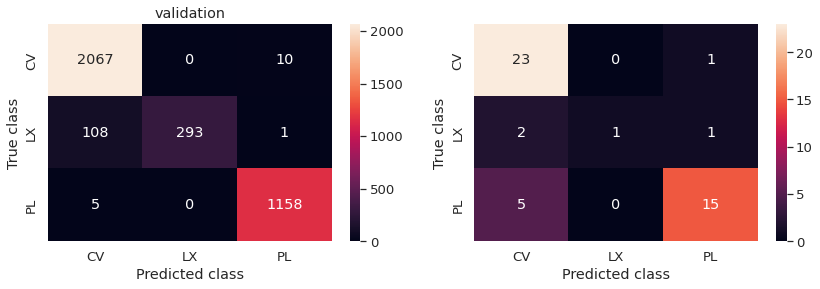

In [344]:
sns.set(font_scale=1.2)
fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize = (14,4))
#sns.boxplot(data = score , ax = ax[0])
cf = confusion_matrix(label_train, clf.predict(value_train) , )
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[0] , xticklabels =class_to_select , yticklabels = class_to_select )
ax[0].set_title('Trainig')
ax[0].set_ylabel('True class')
ax[0].set_xlabel('Predicted class')
cf = confusion_matrix(y_val , clf.predict(x_val) , )
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[1] , xticklabels=class_to_select, yticklabels = class_to_select)
ax[1].set_title('validation')
ax[1].set_ylabel('True class')
ax[1].set_xlabel('Predicted class')
#cf = confusion_matrix(y_val , clf.predict(x_val))
#sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[3])
#plt.savefig('cofusion-matrix-only.jpg')
plt.show()
#score

In [345]:
from sklearn.metrics import precision_score , recall_score 

In [346]:
y_true , y_pred = y_val , clf.predict(x_val)
ps = precision_score(y_true , y_pred , average=None)
rc = recall_score(y_true , y_pred , average=None)
sc = pd.DataFrame(
    np.asarray([ps , rc]) , columns=['CV' , 'LX' , 'PL'] , index=['Precision' , 'Recall']
)
sc

,CV,LX,PL
Precision,0.766667,1.00,0.882353
Recall,0.958333,0.25,0.750000


In [290]:
pd.DataFrame({
    'feat' : x_train.columns.to_list() , 
    'val' : clf.feature_importances_
}).sort_values('val' , ascending=False).reset_index(drop=True)

,feat,val
0,photflux_aper_m,0.403805
1,flux_aper_m,0.102492
2,var_inter_sigma_h,0.085518
3,var_inter_prob_m,0.079965
4,var_inter_prob_s,0.049981
5,var_sigma_b,0.029234
6,hard_ms,0.019476
7,var_inter_index_b,0.017847
8,photflux_aper_h,0.017096
9,var_inter_index_s,0.016180


In [315]:
pred_on = x_val
pred_prob = clf.predict_proba(pred_on)
pred_p_max = [np.amax(p) for p in pred_prob]
pred_prob = pd.DataFrame(pred_prob , columns=['CV' , 'LMXB' , 'PULSAR'])
pred_cl = clf.predict(pred_on)
pred_prob.insert( 0 , 'pred_class' , pred_cl)
pred_prob.insert( 0 , 'max_prob' , pred_p_max)
pred_prob.head()

,max_prob,pred_class,CV,LMXB,PULSAR
0,0.926990,CV,0.926990,0.000917,0.072093
1,0.610822,CV,0.610822,0.000231,0.388947
2,0.999328,CV,0.999328,0.000092,0.000580
3,0.999687,CV,0.999687,0.000001,0.000311
4,0.883830,CV,0.883830,0.000067,0.116102


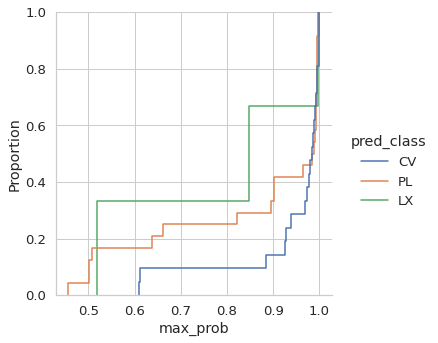

In [316]:
sns.displot(
    data = pred_prob , 
    kind = 'ecdf',
    x = 'max_prob' ,
    hue = 'pred_class'
)
plt.show()

In [350]:
df_all_imp['src_id'].

CV    2101
PL    1183
LX     406
Name: class, dtype: int64

In [353]:
len(df_all_imp[df_all_imp['class']=='CV']['src_id'].unique())

301